In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize



In [20]:
# Función para obtener datos de acciones
def obtener_datos_acciones(simbolos, inicio, fin):
    datos = yf.download(simbolos, start=inicio, end=fin)['Adj Close']
    return datos

# Función para calcular rendimientos
def calcular_rendimientos(datos):
    return datos.pct_change()

# Función para comparar rendimientos con S&P500 y seleccionar acciones
def seleccionar_acciones(datos_acciones, datos_sp500):
    rendimientos_acciones = calcular_rendimientos(datos_acciones)
    rendimientos_sp500 = calcular_rendimientos(datos_sp500)
    superan_sp500 = rendimientos_acciones.mean() > rendimientos_sp500.mean()
    acciones_seleccionadas = superan_sp500.index[superan_sp500].tolist()
    return acciones_seleccionadas


In [21]:
from sklearn.impute import SimpleImputer

# Función para obtener acciones con mejor Sharpe Ratio que el S&P 500
def optimizar_pesos_cartera(rendimientos_acciones, rendimientos_sp500):
    # Asegurarse de que los índices coincidan para facilitar la manipulación de datos
    fechas_comunes = rendimientos_acciones.index.intersection(rendimientos_sp500.index)
    rendimientos_acciones = rendimientos_acciones.loc[fechas_comunes]
    rendimientos_sp500 = rendimientos_sp500.loc[fechas_comunes]

    # Comprobar si hay suficientes datos para la comparación
    if len(rendimientos_acciones) < 2:
        print("No hay suficientes datos para la comparación.")
        return None

    # Imputar valores faltantes en rendimientos_acciones
    imputer_acciones = SimpleImputer(strategy='mean')
    rendimientos_acciones_imputados = pd.DataFrame(imputer_acciones.fit_transform(rendimientos_acciones), index=rendimientos_acciones.index, columns=rendimientos_acciones.columns)

    # Imputar valores faltantes en rendimientos_sp500
    imputer_sp500 = SimpleImputer(strategy='mean')
    rendimientos_sp500_imputados = imputer_sp500.fit_transform(rendimientos_sp500.values.reshape(-1, 1)).flatten()

    # Inicializar un diccionario para almacenar los resultados de la comparación
    acciones_mejores_que_sp500 = {}

    # Comparar rendimientos de cada acción con el rendimiento del S&P 500
    for columna in rendimientos_acciones_imputados.columns:
        # Ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(rendimientos_sp500_imputados.reshape(-1, 1), rendimientos_acciones_imputados[columna])

        # Predicciones
        rendimientos_esperados = modelo.predict(rendimientos_sp500_imputados.reshape(-1, 1))

        # Calcular el Sharpe Ratio
        rendimiento_portafolio = rendimientos_esperados.mean()
        volatilidad_portafolio = rendimientos_esperados.std()
        sharpe_ratio = rendimiento_portafolio / volatilidad_portafolio

        # Comparar Sharpe Ratio con el del S&P 500
        sharpe_ratio_sp500 = rendimientos_sp500_imputados.mean() / rendimientos_sp500_imputados.std()

        # Almacenar las acciones con mejor Sharpe Ratio que el S&P 500
        if sharpe_ratio > sharpe_ratio_sp500:
            acciones_mejores_que_sp500[columna] = sharpe_ratio

    return acciones_mejores_que_sp500

In [22]:
# Definir símbolos de acciones
simbolos_acciones = [
    'AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA',  # Grandes empresas tecnológicas
    'JPM', 'BAC', 'WFC', 'GS', 'C',  # Bancos
    'GE', 'IBM', 'MMM', 'CAT', 'BA',  # Industriales
    'KO', 'PEP', 'MCD', 'WMT', 'PG',  # Consumo masivo
    'XOM', 'CVX', 'BP',                 # Energía
    'INTC', 'AMD', 'NVDA', 'QCOM', 'TXN',  # Semiconductores
    'CSCO', 'IBM', 'ORCL', 'CRM', 'INTU',  # Tecnología empresarial
    'PFE', 'JNJ', 'MRK', 'ABT', 'GSK',  # Farmacéuticas
    'DIS', 'CMCSA', 'NFLX', 'VZ', 'T',  # Medios y entretenimiento, telecomunicaciones
    'LMT', 'RTX', 'NOC', 'HON'          # Defensa y aeroespacial
]
simbolo_sp500 = '^GSPC'

# Definir fechas de inicio y fin
inicio = '2022-01-01'
fin = '2023-01-01'

In [23]:
# Obtener datos de acciones y S&P500
datos_acciones = obtener_datos_acciones(simbolos_acciones, inicio, fin)
datos_sp500 = obtener_datos_acciones(simbolo_sp500, inicio, fin)

# Seleccionar acciones que superan al S&P500
acciones_seleccionadas = seleccionar_acciones(datos_acciones, datos_sp500)

# Obtener rendimientos de las acciones seleccionadas
rendimientos_seleccionados = calcular_rendimientos(datos_acciones[acciones_seleccionadas])

# Obtener rendimientos del S&P500 para comparar
rendimientos_sp500 = calcular_rendimientos(datos_sp500)

# Optimizar pesos de la cartera
pesos_optimizados = optimizar_pesos_cartera(rendimientos_seleccionados, rendimientos_sp500)

# Mostrar resultados
print("Acciones seleccionadas:", acciones_seleccionadas)
print("Pesos optimizados:", pesos_optimizados)

[                       0%%                      ]

[*********************100%%**********************]  46 of 46 completed
[*********************100%%**********************]  1 of 1 completed
Acciones seleccionadas: ['ABT', 'BA', 'BP', 'CAT', 'CVX', 'GE', 'GS', 'GSK', 'HON', 'IBM', 'JNJ', 'JPM', 'KO', 'LMT', 'MCD', 'MRK', 'NOC', 'ORCL', 'PEP', 'PFE', 'PG', 'RTX', 'T', 'TXN', 'WFC', 'WMT', 'XOM']
Pesos optimizados: {'BA': 0.004628476761085992, 'BP': 0.14740334495788746, 'CAT': 0.07591590725093507, 'CVX': 0.23628487147187074, 'GE': -0.019425213575736053, 'GS': -0.01978349402989573, 'HON': 0.029294960611175824, 'IBM': 0.05479676100031117, 'JNJ': 0.06060152565179586, 'JPM': -0.03351368461077687, 'KO': 0.06386533021538013, 'LMT': 0.33326948323484956, 'MCD': 0.012223681817131998, 'MRK': 0.38264388151439477, 'NOC': 0.3072446356548075, 'ORCL': -0.0028277483247934835, 'PEP': 0.04764424713016379, 'PFE': -0.01700123636210138, 'PG': -0.01309056197114171, 'RTX': 0.08215925348931759, 'T': 0.0354268357866241, 'TXN': -0.015531632878014727, 'WFC': -0.03

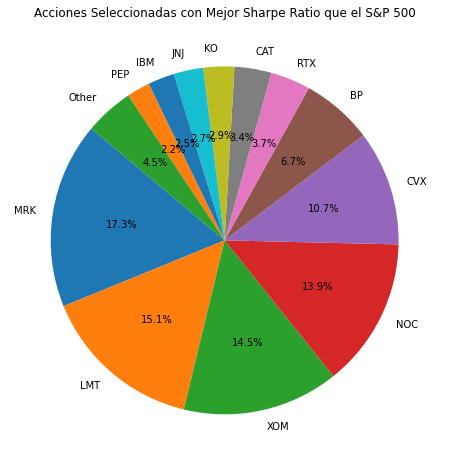

In [27]:

import matplotlib.pyplot as plt

# Supongamos que tienes los pesos calculados y las acciones seleccionadas
acciones_pesos_filtrados = {accion: peso for accion, peso in pesos_optimizados.items() if peso >= 0}

# Calcular el total de los pesos
total_pesos = sum(acciones_pesos_filtrados.values())

# Crear un diccionario con acciones y pesos agrupados
acciones_agrupadas = {}
umbral = 0.02  # 2%

# Filtrar las acciones que cumplen el umbral y ordenarlas por peso
acciones_candidatas = sorted([(accion, peso) for accion, peso in acciones_pesos_filtrados.items() if peso / total_pesos >= umbral], key=lambda x: x[1], reverse=True)

# Iterar sobre las acciones candidatas y agregarlas al diccionario
for accion, peso in acciones_candidatas:
    acciones_agrupadas[accion] = peso

# Sumar los pesos restantes y agregarlos a la categoría "resto"
peso_restante = total_pesos - sum(acciones_agrupadas.values())
acciones_agrupadas.setdefault('Other', 0)
acciones_agrupadas['Other'] += peso_restante

# Crear un gráfico de tarta con acciones agrupadas
plt.figure(figsize=(8, 8))

plt.pie(acciones_agrupadas.values(), labels=acciones_agrupadas.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Acciones Seleccionadas con Mejor Sharpe Ratio que el S&P 500')
plt.show()

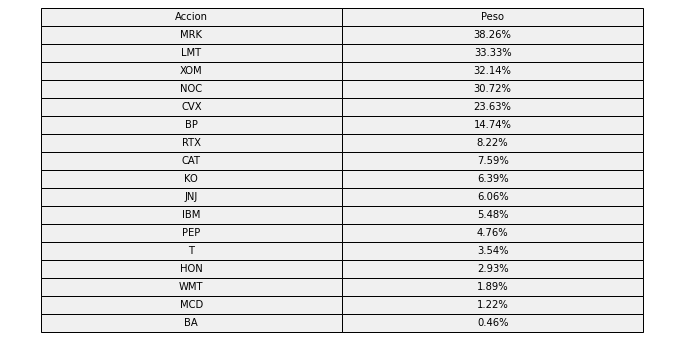

In [25]:

# Crear un DataFrame desde el diccionario
df_acciones_pesos = pd.DataFrame(list(acciones_pesos_filtrados.items()), columns=['Accion', 'Peso'])

# Convertir los pesos a porcentajes
df_acciones_pesos['Peso'] = df_acciones_pesos['Peso'] * 100

# Ordenar el DataFrame por peso de mayor a menor
df_acciones_pesos = df_acciones_pesos.sort_values(by='Peso', ascending=False)

# Crear un gráfico de tarta
plt.figure(figsize=(12, 6))

plt.axis('off')  # Desactivar ejes

# Formatear la tabla para incluir el símbolo de porcentaje y dos decimales
tabla = plt.table(cellText=df_acciones_pesos.values,
                  colLabels=df_acciones_pesos.columns,
                  cellLoc='center',
                  loc='center',
                  colColours=['#f0f0f0']*(len(df_acciones_pesos.columns)),
                  cellColours=[['#f0f0f0', '#f0f0f0']] * len(df_acciones_pesos),
                  colWidths=[0.3, 0.3])

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.5, 1.5)  # Escala de la tabla

# Formatear celdas para incluir el símbolo de porcentaje y dos decimales
for i in range(1, len(df_acciones_pesos)+1):  # Excluyendo la fila de encabezado
    tabla[(i, 1)].get_text().set_text('{:.2f}%'.format(df_acciones_pesos.iloc[i-1, 1]))

plt.show()

In [26]:
# Filtrar acciones seleccionadas que también tienen pesos
acciones_con_pesos = [accion for accion in acciones_seleccionadas if accion in pesos_optimizados]

# Verificar si hay al menos dos acciones con pesos
if len(acciones_con_pesos) < 2:
    print("No hay suficientes acciones con pesos para la comparación.")
else:
    # Filtrar el DataFrame rendimientos_seleccionados solo para las acciones con pesos
    rendimientos_seleccionados_con_pesos = rendimientos_seleccionados[acciones_con_pesos]

    # Obtener los pesos optimizados solo para las acciones con pesos
    pesos_optimizados_con_pesos = {accion: pesos_optimizados[accion] for accion in acciones_con_pesos}

    # Calcular rendimientos del portafolio optimizado solo para acciones con pesos
    rendimientos_portafolio = (rendimientos_seleccionados_con_pesos * pd.Series(pesos_optimizados_con_pesos)).sum(axis=1)

    # Calcular volatilidad del portafolio
    volatilidad_portafolio = rendimientos_portafolio.std()

    rendimiento_acumulado_portafolio = (1 + rendimientos_portafolio).cumprod() - 1
    rendimiento_medio_diario = rendimientos_portafolio.mean()
    rendimiento_medio_anual = rendimiento_medio_diario * 252  # Suponiendo 252 días de negociación al año
    print("Rendimiento Medio Diario del Portafolio:", round(rendimiento_medio_diario, 5)*100,"%")
    print("Rendimiento Medio Anual del Portafolio:", round(rendimiento_medio_anual, 3)*100,"%")
    print("Volatilidad del Portafolio:", round(volatilidad_portafolio, 3)*100,"%")





Rendimiento Medio Diario del Portafolio: 0.345 %
Rendimiento Medio Anual del Portafolio: 87.0 %
Volatilidad del Portafolio: 2.5 %
